In [26]:
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from collections import defaultdict
import pytesseract
from pytesseract import Output

import shutil

In [27]:
plt.rcParams['figure.figsize'] = [10, 20]

In [28]:
blu_path = Path("../blu")
dataset_path = blu_path.joinpath("dataset")
annotated_dataset_path = blu_path.joinpath("annotated")

In [29]:
def parse_annotation(obj, width_ratio, height_ratio):
    """Pull all values of specified key from nested JSON."""
    arr = defaultdict(list)
    

    def extract(obj, arr):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            if "componentLabel" in obj.keys():
                label = obj["componentLabel"]
                bounds = obj.get("bounds", [])
                x1,y1,x2,y2 = bounds
                pt1 = (math.ceil(x1 * width_ratio), math.ceil(y1 * height_ratio))
                pt2 = (math.ceil(x2 * width_ratio), math.ceil(y2 * height_ratio))
                bounds = {
                    "start": pt1,
                    "end": pt2
                }
                class_name = obj.get("class", "")
                resource_id = obj.get("resource-id", "")
                text = obj.get("text", "")
                
                arr[label].append({
                    "class_name": class_name,
                    "bounds": bounds,
                    "resource_id": resource_id,
                    "text": text
                })
                
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr)
        return arr

    results = extract(obj, arr)
    return results

In [30]:
dataset_details = pd.read_csv(blu_path.joinpath("dataset.csv"))

In [31]:
counter = 0
for row in dataset_details.iterrows():
    counter +=1
    data = row[1]
    root = dataset_path.joinpath(data[0],data[1])
    annotated_root = annotated_dataset_path.joinpath(data[0],data[1])
    annotated_root.mkdir(parents=True, exist_ok=True)
    
    image_path = root.joinpath(f"{data[2]}.jpg").as_posix()
    
    json_path = root.joinpath(f"{data[2]}.json").as_posix()
    new_json_path = annotated_root.joinpath(f"annotation_{data[2]}.json").as_posix()

    image = cv2.imread(image_path)

    image_height,image_width,_ = image.shape

    with open(json_path, "r") as f:
        try:
            orig_annotation = json.load(f)
            _,_,width,height = orig_annotation["bounds"]
            width_ratio = image_width / width
            height_ratio = image_height / height
            annotation = parse_annotation(orig_annotation, width_ratio, height_ratio)
            annotation["image_size"] = (image_width, image_height)
        except:
            print(orig_annotation["bounds"], json_path)
        
    with open(new_json_path, "w") as f:
        json.dump(annotation, f, indent=2)
        
print(counter)

3416


In [34]:
root = dataset_path.joinpath("Social","ASKfm")
annotated_root = annotated_dataset_path.joinpath("Social","ASKfm")
image_path = root.joinpath(f"1.jpg").as_posix()
json_path = annotated_root.joinpath(f"annotation_1.json").as_posix()

image = cv2.imread(image_path)

with open(json_path, "r") as f:
    annotation = json.load(f)

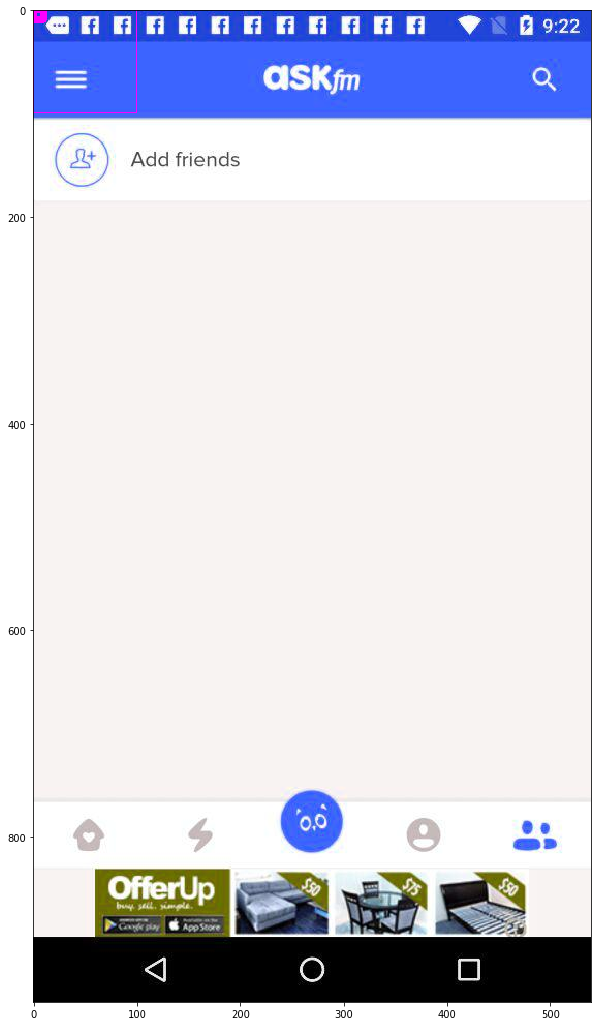

In [36]:
original_image = image.copy()
cv2.rectangle(image, (0,0), (100,100), color=(255,0,255), thickness=1)

plt.imshow(image)

[{'class_name': 'android.support.v7.widget.AppCompatTextView', 'bounds': {'start': [95, 134], 'end': [201, 159]}, 'resource_id': 'com.askfm:id/addFriendsHeaderTitle', 'text': 'Add friends'}]


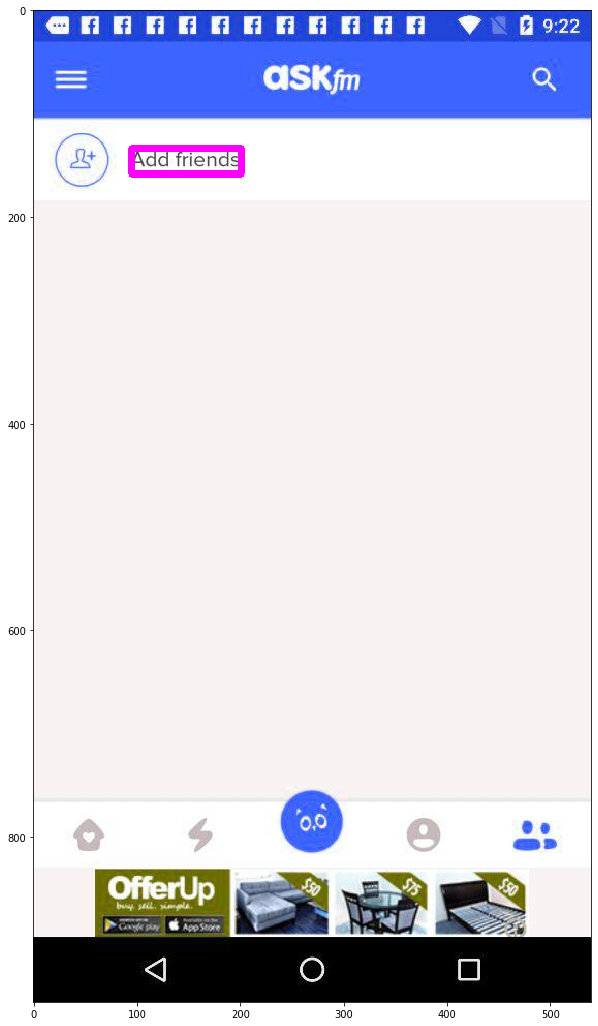

In [24]:
image = original_image.copy()
for k,v in annotation.items():
    if k != "Text":
        continue
    print(v)
    for item in v:
        bounds = item["bounds"]
        x1,y1 = bounds["start"]
        x2, y2 = bounds["end"]
        cv2.rectangle(image, (x1,y1), (x2,y2), color=(255,0,255), thickness=5)

plt.imshow(image)

{'class_name': 'com.facebook.ui.titlebar.Fb4aTitleBar', 'bounds': {'start': [0, 63], 'end': [1080, 189]}, 'resource_id': 'com.facebook.katana:id/titlebar', 'text': ''}


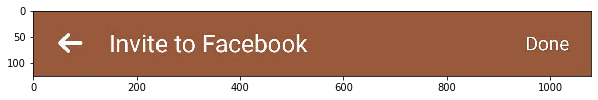

In [11]:
item = annotation["Toolbar"][0]
bounds = item["bounds"]

x1,y1 = bounds["start"]
x2,y2 = bounds["end"]

print(item)

cropped = original_image[y1:y2,x1:x2,:]
plt.imshow(cropped)

In [12]:
img = cropped.copy()
d = pytesseract.image_to_data(img, output_type=Output.DICT)
n_boxes = len(d['level'])
for i in range(n_boxes):
    if d['conf'][i] == '-1':
        continue

    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    

plt.imshow(img)

TesseractNotFoundError: tesseract is not installed or it's not in your path